# Airbnb - Q1 (Boston & Seattle) - Prepare Data & Initial Analysis

This notebook has been created to process the data into the format needed in order to anaswer all of the questions including dealing with NaN's, dropping unwanted columns, one-hot encoding and reformatting the data. After the initial cleaning we will looking into the first question on seasonality before preparing the data for the modelling step where we will look at creating a prediction model and feature importance.

In this notebook initial analysis will be performed that will cover the first question and then further processing will take place prior to performing ML. The question answered is:

Q1) Do the prices throughout the year have a seasonal trend in either market?

## 1. Imports

In [1]:
# Imports basic functions
import pandas as pd
import numpy as np

# Imports functions for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import matplotlib.style as style

# Sklearn for data prep
from sklearn.preprocessing import MultiLabelBinarizer
import re

# Imports custom made airbnb package
import airbnb_pkg as airbnb

## 2. Functions

In [2]:
def plot_histogram(data, column, market, ax, binsize=50, y_label='', x_label='', color='blue'):
    """
    Function to plot standard histograms (Can be used for individual or side by side plots)
    """
    # Plots the Seattle Graph with title & axis
    sns.distplot(data[column], kde=False, color=color, bins=binsize, ax=ax)
    
    # Sets up the title based on the plotting column and the market    
    ax.set_title(f"{market} - Listing Prices", fontsize=25)
    
    # Sets the y and x labels
    ax.set_ylabel(y_label, fontsize=24)
    ax.set_xlabel(x_label, fontsize=24)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    
    # Removes spines and changes layout to tight
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def plot_line(data, ax, color, alpha=.7, ls='-', lw=5, label=None):
    """
    plots the standard line graph
    """
    ax.plot(data, color=color,
            alpha=alpha, ls=ls,
            linewidth=lw, label=label)

## 3. Basic Setup (Read data, create global variables etc.)

In [3]:
# Plotting settings
style.use('seaborn-poster') #sets the size of the charts
style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = "sans serif"

In [4]:
# Read in the .csv files for Seattle 
Seattle_Cal = pd.read_csv('Data/Seattle/calendar.csv')
Seattle_List = pd.read_csv('Data/Seattle/listings.csv')

# Read in the .csv files for Boston 
Boston_Cal = pd.read_csv('Data/Boston/calendar.csv')
Boston_List = pd.read_csv('Data/Boston/listings.csv')

# Please note the reviews.csv data will not be used throughout this project

## 4. Processing & Analysis

### Basic Initial Cleaning

All of the modules with decriptions of why steps have been taken are in the package airbnb_pkg in the __init__.py file. Please take a look for details.

In [5]:
# Initial clean up of the calender data
Seattle_Cal_clean = airbnb.clean_calendar_data(Seattle_Cal)
Boston_Cal_clean = airbnb.clean_calendar_data(Boston_Cal)

# Initial clean up of the listings data
Seattle_List_clean = airbnb.clean_listings_data(Seattle_List)
Boston_List_clean = airbnb.clean_listings_data(Boston_List)

/Users/warwick.rommelrath/Udacity/Airbnb_Data_Analysis/airbnb_pkg/__init__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for x in data['price']]
/Users/warwick.rommelrath/Udacity/Airbnb_Data_Analysis/airbnb_pkg/__init__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['date'] = pd.to_datetime(data['date'])


Columns dropped: {'square_feet'}
Number of rows dropped: 0
Columns dropped: {'square_feet'}
Number of rows dropped: 0


## Q1 - Do the prices throughout the year have a seasonal trend in either market?

In [6]:
# First I will look at the price metric in the calender data
Seattle_prices = Seattle_Cal_clean.groupby('listing_id').median().round()
Boston_prices = Boston_Cal_clean.groupby('listing_id').median().round()

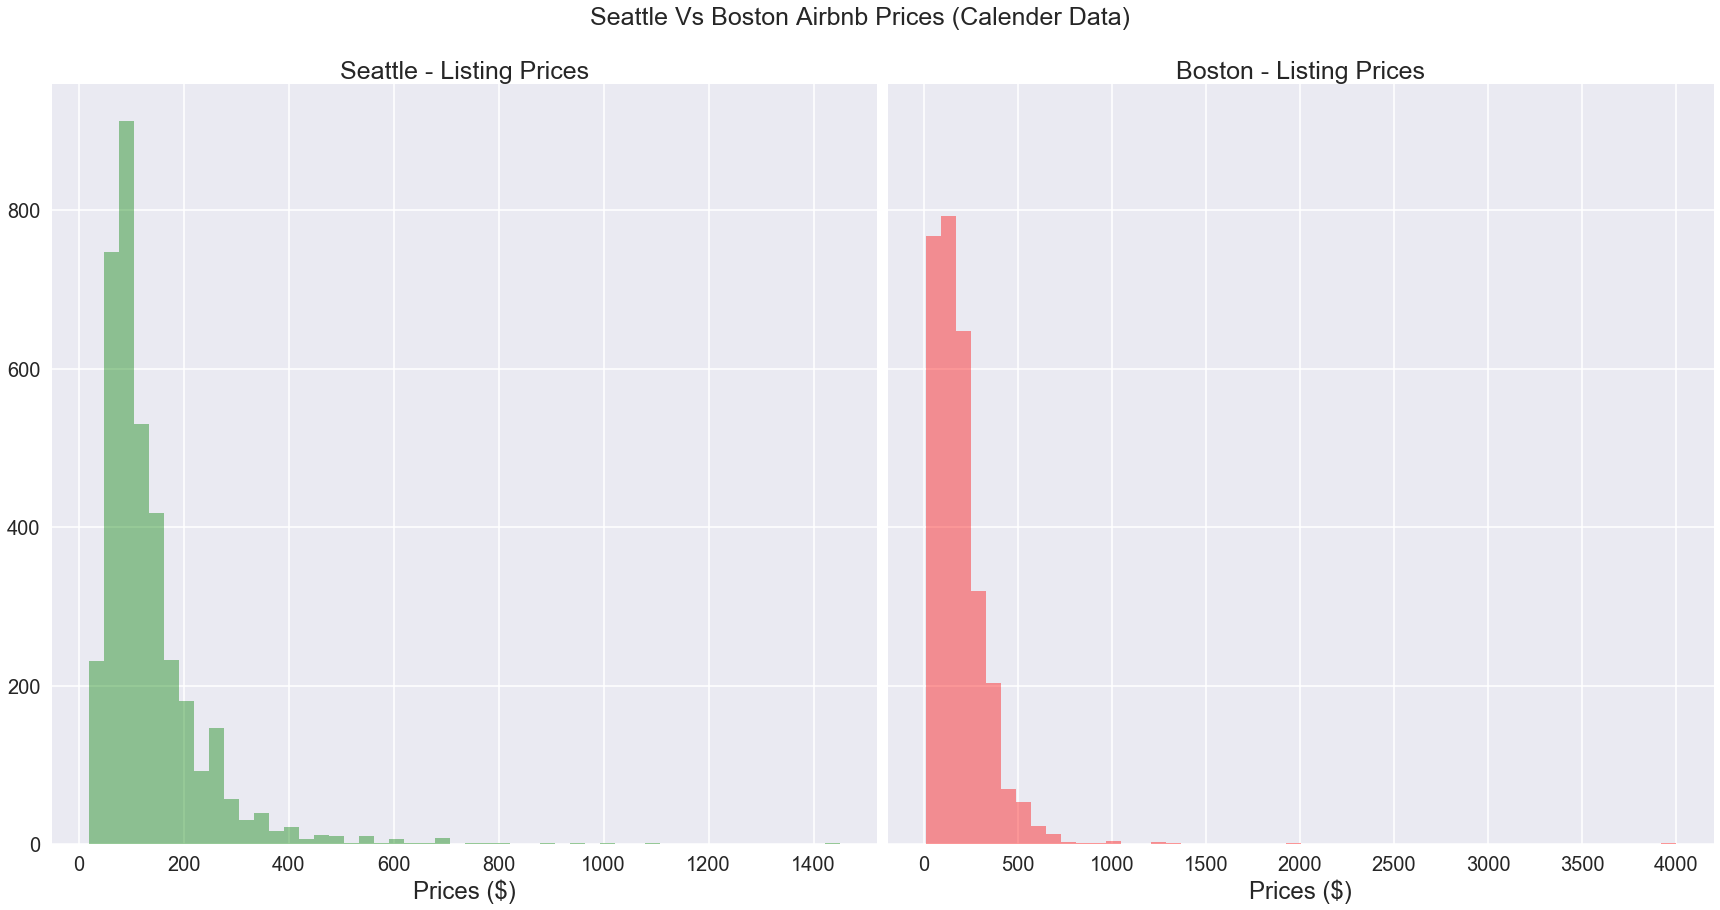

In [7]:
# Setup the graphs and add the main title
fig, (ax1, ax2) = plt.subplots(figsize=(24,12), ncols=2, sharey=True)
plt.suptitle("Seattle Vs Boston Airbnb Prices (Calender Data)", y = 1.05, fontsize=25)

# Plots the Seattle Graph with title & axis
plot_histogram(Seattle_prices, 'price', 'Seattle', ax1, binsize=50, x_label='Prices ($)', color='green')

# Plots the Boston Graph with title & axis
plot_histogram(Boston_prices, 'price', 'Boston', ax2, binsize=50, x_label='Prices ($)', color='red')

plt.tight_layout()

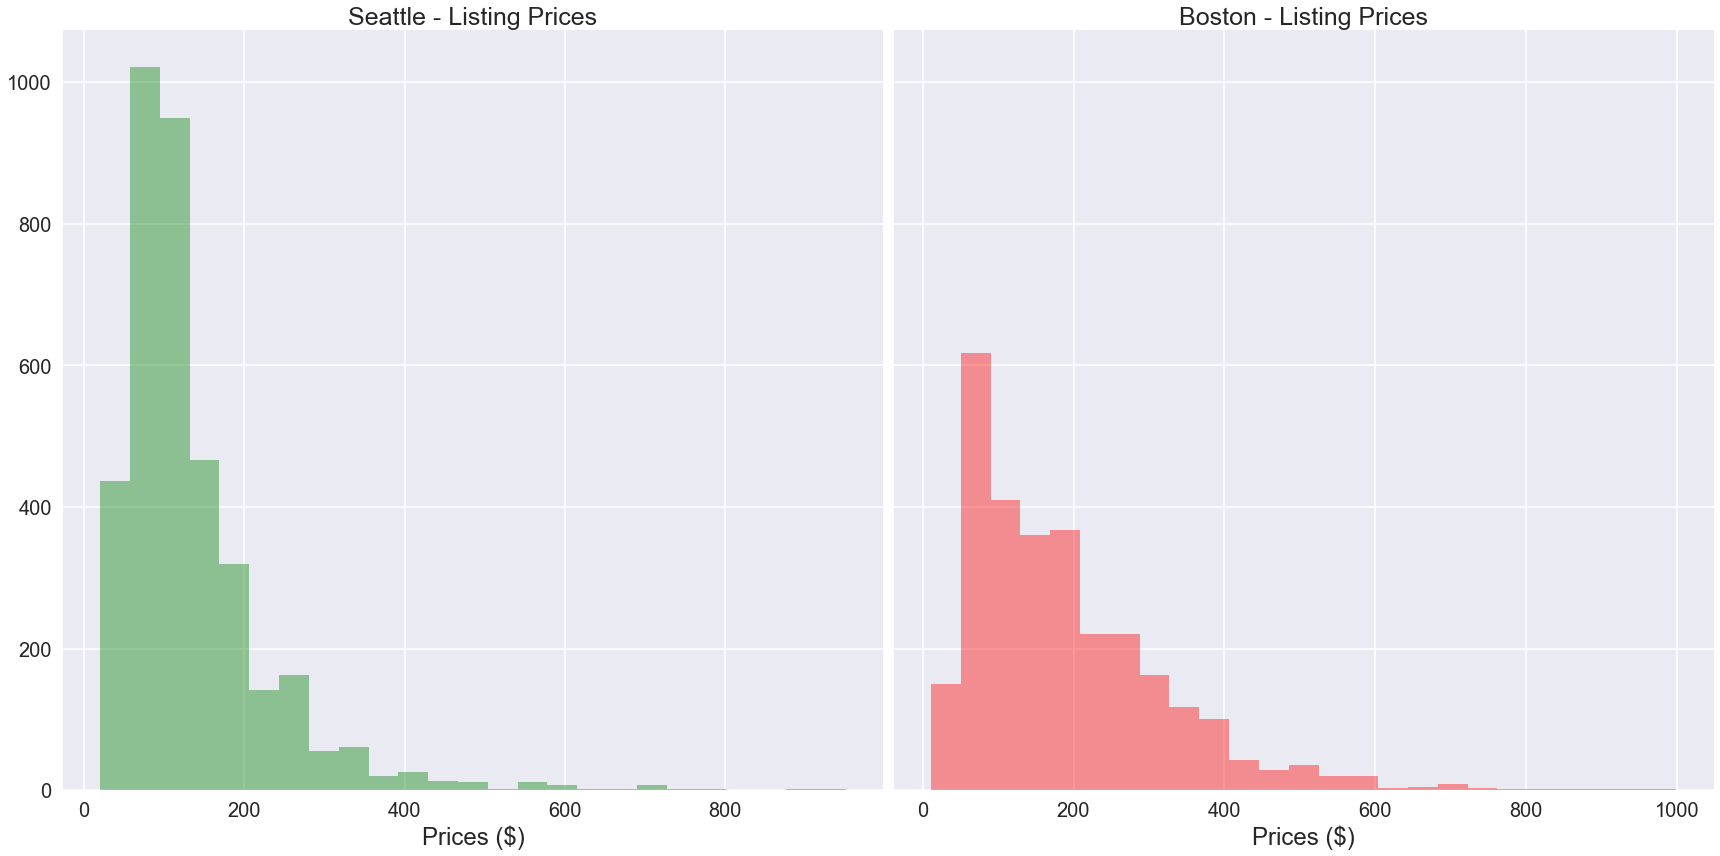

In [8]:
# Setup the graphs and add the main title
fig, (ax1, ax2) = plt.subplots(figsize=(24,12), ncols=2, sharey=True)
# plt.suptitle("Seattle Vs Boston | Airbnb | Prices - Calender Data", y = 1.05, fontsize=30, )

# Plots the Seattle Graph with title & axis
plot_histogram(Seattle_prices[Seattle_prices['price'] < 1000], 'price', 'Seattle', ax1, binsize=25, x_label='Prices ($)', color='green')

# Plots the Boston Graph with title & axis
plot_histogram(Boston_prices[Boston_prices['price'] < 1000], 'price', 'Boston', ax2, binsize=25, x_label='Prices ($)', color='red')

F

The above histograms show that the Boston data does have a few very large outliers at (2000 & 4000+) confirming in this case that the mean the data will be skewed signifcantly. However looking at the lower end we can also see that properties are more spread out across the range as a whole whereas Seattle has a huge spike around 100. From this we can determine that according to the Calender data Boston on average has higher listing prices than Seattle.

In [9]:
# Interpolate the data to fill missing days for each property
Seattle_Int = Seattle_Cal_clean.groupby(['date','listing_id']).mean().unstack(level=1).interpolate().ffill().bfill()

# Take the average value across all of the properties
Seattle_ACPD = pd.DataFrame(Seattle_Int.median(axis=1), columns=['Price ($)'])

# Calculate the cost per month across all properties
Seattle_CPM = Seattle_ACPD.resample('M').sum().round()

# Drop the last month as it's not complete
Seattle_CPM = Seattle_CPM.iloc[:-1,:]

# Normalise the dataF
Seattle_CPM = Seattle_CPM/Seattle_CPM.max()*100

Seattle_CPM.head()

,Price ($)
date,
2016-01-31,80.759200
2016-02-29,85.047812
2016-03-31,93.074471
2016-04-30,93.335265
2016-05-31,98.609099


In [10]:
# Prepare the Boston Data
# Interpolate the data to fill missing days for each property
Boston_Int = Boston_Cal_clean.groupby(['date','listing_id']).mean().unstack(level=1).interpolate().ffill().bfill()

# Take the average value across all of the properties
Boston_ACPD = pd.DataFrame(Boston_Int.median(axis=1), columns=['Price ($)'])

# Calculate the cost per month across all properties
Boston_CPM = Boston_ACPD.resample('M').sum().round()

# Drop the last month as it's not complete
Boston_CPM = Boston_CPM.iloc[1:-1,:]

# Normalise the data
Boston_CPM = Boston_CPM/Boston_CPM.max()*100

Boston_CPM.head()

,Price ($)
date,
2016-10-31,99.171382
2016-11-30,93.088116
2016-12-31,94.219887
2017-01-31,93.977365
2017-02-28,84.882781


/Users/warwick.rommelrath/.pyenv/versions/3.7.4/envs/stuff/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


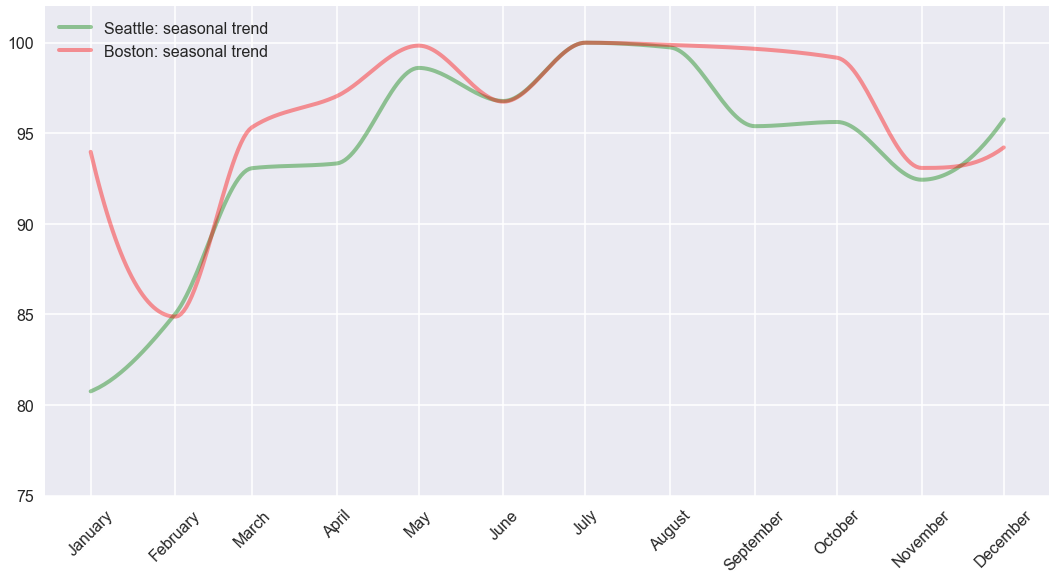

In [11]:
# Plot both of the trends over a year to see how they change
fig, ax = plt.subplots(figsize=(18,9))

# plt.suptitle("Seattle Vs Boston | Seasonal Trend | Listing prices", y = 0.98, fontsize=18)

# Set the axis to the same year for the purpose of comparison
Seattle_CPM = Seattle_CPM.set_index(pd.DatetimeIndex(
                                    [date(2017, x.month, 28).strftime("%Y-%m-%d") for x in Seattle_CPM.index]))
Boston_CPM = Boston_CPM.set_index(pd.DatetimeIndex(
                                    [date(2017, x.month, 28).strftime("%Y-%m-%d") for x in Boston_CPM.index]))

# Plot both of the seasonal trends onto a graph
plot_line(Seattle_CPM.resample('1D').interpolate('pchip'), ax, 'green', alpha=.4, ls='-', lw=4, label='Seattle: seasonal trend')
plot_line(Boston_CPM.resample('1D').interpolate('pchip'), ax, 'red', alpha=.4, ls='-', lw=4, label='Boston: seasonal trend')

# Set the x-labels and y limits  
x_ticks = pd.to_datetime(Seattle_CPM.index)

x_pos = [pd.to_datetime(Seattle_CPM.index[2])] \
        + list(Seattle_CPM.index[1:-1]) \
        + [pd.to_datetime(['2019-12-28'])]

ax.set_xticklabels([pd.to_datetime(x).strftime('%B') for x in x_ticks],
                   rotation=45, 
                   fontsize=15)
ax.set_xticks(x_ticks)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

ax.set_ylim(75, 102)
ax.tick_params(axis="y")

# Plots the Legend
h1, l1 = ax.get_legend_handles_labels()
ax.legend(loc=2, frameon=False)

# Removes spines and changes layout to tight
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

##### Answer: Do the prices throughout the year have a seasonal trend in either market?

Interestingly the seasonal trend for these two markets are much more similar than expected considering they are on opposite sides of the US. They both have relavitely low seasonality with only Feb diverting from the rest of the year massively. Seattle also shows a low Januray well below that of Boston. Better results could be achieved by looking at seasonality of price over multiple years but this is unavalible in this data. It would also be great to compare this to avaliblity of the properties to see if properties are lowering prices in months when avaliblity is higher. That is out of the scopre of this project at this point.

### Machine Learning Pre-processing

In [12]:
# Merge Calender & Listing data (data_merge is located in the .py package)
Seattle_merged = airbnb.data_merge(Seattle_Cal_clean, Seattle_List_clean)
Boston_merged = airbnb.data_merge(Boston_Cal_clean, Boston_List_clean)

# Drop the extra price columns as they are not needed for this analysis (They are similar to the calender price)
Seattle_drop = Seattle_merged.drop(columns=['price','weekly_price','monthly_price'])
Boston_drop = Boston_merged.drop(columns=['price','weekly_price','monthly_price'])

In [13]:
# Check datatypes to see catagorical variables
Seattle_drop.dtypes

Cal_price                      float64
neighbourhood                   object
zipcode                         object
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
bed_type                        object
amenities                       object
security_deposit                 int64
cleaning_fee                     int64
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
reviews_per_month              float64
dtype: object

Their are two types of catagorical variables in the data the numrical ones like accommodates, bedrooms etc as these are not continous data and the non-numerical neighbourhood, zipcode, bed_type etc. For the prupose of removing NaN's I will add the mode in for the numerical values but the none numerical will need further investigation.

In [14]:
pd.isnull(Seattle_drop).sum()/len(Seattle_drop)*100

Cal_price                       0.000000
neighbourhood                  10.958904
zipcode                         0.188020
property_type                   0.026860
room_type                       0.000000
accommodates                    0.000000
bathrooms                       0.429761
bedrooms                        0.161160
beds                            0.026860
bed_type                        0.000000
amenities                       0.000000
security_deposit                0.000000
cleaning_fee                    0.000000
number_of_reviews               0.000000
review_scores_rating           16.706957
review_scores_accuracy         17.002417
review_scores_cleanliness      16.868117
review_scores_checkin          17.002417
review_scores_communication    16.814397
review_scores_location         16.921837
review_scores_value            16.948697
reviews_per_month              16.169756
dtype: float64

In [15]:
# Replace Numerical Catagorical Variables with mode
numeric_cata = ['review_scores_rating','accommodates','bathrooms','bedrooms','beds','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']
Seattle_drop[numeric_cata] = Seattle_drop[numeric_cata].fillna(Seattle_drop.mode().iloc[0])
                                                               
# Replace reviews with the average rounded as they are the only other numerical columns with missing values
reviews_data = ['reviews_per_month']
Seattle_drop['reviews_per_month'] = Seattle_drop['reviews_per_month'].fillna(Seattle_drop['reviews_per_month'].median().round())

The none catagorical variables will be a bit more difficult and dealing with them will be performed wit in this next part.

Neighbourhood has the biggest amount of missing data and my be hard to recover it is likely that zipcode will give me a similar sort of idea about location on price as well. It might be worth trying to fill in this using the neighbourhood data (A neighbourhood is likely to be consistently in the same zip code but not vice-versa).

In [16]:
for x in Seattle_drop[Seattle_drop['zipcode'].isnull()]['neighbourhood']:
    print(Seattle_drop[Seattle_drop['neighbourhood'] == x]['zipcode'].head())

108468    98119
160222    98109
175576    98119
186328    98109
241016    98119
Name: zipcode, dtype: object
20927    98107
20928    98107
25002    98117
30712    98117
37234    98117
Name: zipcode, dtype: object
2134911      NaN
2586642    98119
4271174    98199
5002964    98119
6438013    98119
Name: zipcode, dtype: object
2332949      NaN
2459519    98102
3379116    98102
3479851    98102
4940379    98102
Name: zipcode, dtype: object
Series([], Name: zipcode, dtype: object)
Series([], Name: zipcode, dtype: object)
Series([], Name: zipcode, dtype: object)


Looking at the data further it turns out that a number of the properties have multiple zip codes per neighbourhood and that a few have the rows have missing data for both. It might be worth dropping the bad rows afterall. The other missing values are in property type but this is a minimal amout of data and so can probably also be dropped.

In [17]:
# Drop the NaN's and unwanted columns
Seattle_drop = Seattle_drop.drop(columns=['neighbourhood'])
Seattle_drop = Seattle_drop.dropna()

# Some processing needs to be used to edit bad zipcodes
Seattle_drop['zipcode'] = [re.sub(r'\b(\d{1,4}|\d{6,}|\D)\b','',x)[0:5] for x in Seattle_drop['zipcode']]

pd.isnull(Seattle_drop).sum()/len(Seattle_drop)*100

Cal_price                      0.0
zipcode                        0.0
property_type                  0.0
room_type                      0.0
accommodates                   0.0
bathrooms                      0.0
bedrooms                       0.0
beds                           0.0
bed_type                       0.0
amenities                      0.0
security_deposit               0.0
cleaning_fee                   0.0
number_of_reviews              0.0
review_scores_rating           0.0
review_scores_accuracy         0.0
review_scores_cleanliness      0.0
review_scores_checkin          0.0
review_scores_communication    0.0
review_scores_location         0.0
review_scores_value            0.0
reviews_per_month              0.0
dtype: float64

Now we have dealt with all of the NaN's in the data we can edit the amenities collumn and perform one hot encoding on all of the catagorical varaiables

Zipcode, Neighnourhood, property_type, room_type and bed_type all neede encoding. Amenities needs some further processing before that step.

In [18]:
# Turn the amenities data into a list of amenities
Seattle_drop['amenities'] = [x.replace('{','').replace('}','').replace('"','').split(',') for x in Seattle_drop['amenities']]

In [19]:
# One hot encode the amenities data
mlb = MultiLabelBinarizer()
amenities = pd.DataFrame(mlb.fit_transform(Seattle_drop.pop('amenities')),
                          columns=mlb.classes_,
                          index=Seattle_drop.index)
amenities.head()

,,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,...,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
4291,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,0,1,1,0,0,1
5682,0,1,0,0,0,0,1,0,0,0,...,0,1,1,0,0,1,0,0,0,1
6606,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
7369,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,0,0,1
9419,0,0,1,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,1


Amenities is now successfully one-hot-encoded and is likely to have some impact on property listing value as higher value places will have more amenities. Next we can do the same on all of the catagorical variables.

In [20]:
non_numeric_cata = ['zipcode', 'property_type', 'room_type', 'bed_type']

In [21]:
# we can get dummies the rest of the non-numeric catagorical data
nn_cata = pd.get_dummies(Seattle_drop[non_numeric_cata])

Now all of the above needs to be added to a function so it can easily be performed on the Boston data & ran on the whole dataframe. For none catagorical variables in the function I will repalce NaNs with an average or mode where appropriate.

In [22]:
Seattle_input = Seattle_drop.drop(columns=['zipcode', 'property_type', 'room_type', 'bed_type'])

Seattle_join_temp = pd.merge(Seattle_input, nn_cata, left_index=True, right_index=True)
Seattle_join =  pd.merge(Seattle_join_temp, amenities, left_index=True, right_index=True)

It's possible at this point to encode all of the discrete variables (bathrooms, beds etc). However, as they actually have some numerical scale and relationship I'm going to leave them as they are for this analysis.

In [23]:
Seattle_join.head()

,Cal_price,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,...,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
4291,82.0,2,1.0,1.0,1.0,0,30,35,92.0,10.0,...,0,1,1,0,0,1,1,0,0,1
5682,53.0,2,1.0,1.0,1.0,0,25,297,96.0,10.0,...,0,1,1,0,0,1,0,0,0,1
6606,90.0,2,1.0,1.0,1.0,200,40,52,93.0,9.0,...,0,1,0,0,0,1,0,0,0,1
7369,85.0,2,1.0,1.0,1.0,0,0,40,94.0,10.0,...,0,1,1,0,0,1,1,0,0,1
9419,90.0,2,3.0,1.0,1.0,100,0,79,91.0,9.0,...,0,1,1,0,0,0,0,0,0,1


In [24]:
# All of the above processing can then be put into a module to be used on both datasests in the modelling notebook
def ML_preprocessing(calendar_data, listings_data):
    """
    This function has been created to prep the data ready for ML
    """
    
    # Run the basic cleaning functions  
    cal_cleaned = airbnb.clean_calendar_data(calendar_data)
    list_cleaned = airbnb.clean_listings_data(listings_data)
    
    # Merge the two datasets
    data_merged = airbnb.data_merge(cal_cleaned, list_cleaned)
    
    # Drop all unwanted columns    
    data_drop = data_merged.drop(columns=['price','weekly_price','monthly_price','neighbourhood'])
    
    # Replace NaN's in Numerical Catagorical Variables with mode
    numeric_cata = ['review_scores_rating','accommodates',
                    'bathrooms','bedrooms','beds',
                    'review_scores_accuracy','review_scores_cleanliness',
                    'review_scores_checkin','review_scores_communication',
                    'review_scores_location','review_scores_value']
    data_drop[numeric_cata] = data_drop[numeric_cata].fillna(data_drop.mode().iloc[0])
                                                               
    # Replace NaN's in reviews_per_month with the average rounded
    rev_col = ['reviews_per_month']
    data_drop[rev_col] = data_drop[rev_col].fillna(data_drop[rev_col].median().round())
    
    # Drop any other rows with NaN's (Should be minimal)     
    data_drop = data_drop.dropna()
    
    # Some processing needs to be used to edit bad zipcodes
    data_drop['zipcode'] = [re.sub(r'\b(\d{1,4}|\d{6,}|\D)\b','',x)[0:5] 
                            for x in data_drop['zipcode']]
    
    # Turn the amenities data into a list of amenities
    data_drop['amenities'] = [x.replace('{','').replace('}','').replace('"','').split(',') 
                                 for x in data_drop['amenities']]
    
    # One hot encode the 'amenities data'
    mlb = MultiLabelBinarizer()
    amenities = pd.DataFrame(mlb.fit_transform(data_drop.pop('amenities')),
                              columns=mlb.classes_,
                              index=data_drop.index)
    
    # Create dummies for all of the other catagorical columns
    non_numeric_cata = ['zipcode', 'property_type', 'room_type', 'bed_type']
    nn_cata = pd.get_dummies(data_drop[non_numeric_cata])
    
    # Merge the data frames & drop extra columns to create the ML Input
    data_drop = data_drop.drop(columns=non_numeric_cata)
    data_temp = pd.merge(data_drop, nn_cata, left_index=True, right_index=True)
    data_output =  pd.merge(data_temp, amenities, left_index=True, right_index=True)
    
    return data_output

In [25]:
Boston_data = ML_preprocessing(Boston_Cal, Boston_List)

Columns dropped: {'square_feet'}
Number of rows dropped: 0


In [26]:
Boston_data.head()

,Cal_price,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,...,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
3353,36.0,1,1.0,1.0,1.0,100,50,34,90.0,9.0,...,1,0,0,0,1,0,0,1,1,1
5506,145.0,2,1.0,1.0,1.0,0,40,36,91.0,9.0,...,0,0,0,1,1,0,0,1,0,0
6695,195.0,4,1.0,1.0,2.0,0,70,47,95.0,9.0,...,1,0,0,1,1,0,0,1,0,0
6976,65.0,2,1.0,1.0,1.0,0,0,41,98.0,10.0,...,1,0,0,1,1,0,0,1,1,1
8792,154.0,3,1.0,1.0,1.0,1000,250,18,91.0,10.0,...,0,0,0,1,0,0,0,1,0,0


The data and function above now has all NaN's removed and is in a format ready to implement a ML model.